# Analysing variability and compensation mechansims with conditional distributions

A central advantage of `sbi` over parameter search methods such as genetic algorithms is that the posterior captures **all** models that can reproduce experimental data. This allows us to analyse whether parameters can be variable or have to be narrowly tuned, and to analyse compensation mechanisms between different parameters. See also [Marder and Taylor, 2011](https://www.nature.com/articles/nn.2735?page=2) for further motivation to identify all models that capture experimental data.

In this tutorial, we will show how one can use the posterior distribution to identify whether parameters can be variable or have to be finely tuned, and how we can use the posterior to find potential compensation mechanisms between model parameters. To investigate this, we will extract **conditional distributions** from the posterior inferred with `sbi`.


Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/07_conditional_distributions.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/07_conditional_distributions.ipynb) in the `sbi` repository.


## Main syntax


Asssuming you have already obtained `posterior`.

```python
from sbi.analysis import conditional_corrcoeff, conditional_pairplot

# Plot slices through posterior, i.e. conditionals.
_ = conditional_pairplot(
    density=posterior,
    condition=posterior.sample((1,)),
    limits=torch.tensor([[-2.0, 2.0], [-2.0, 2.0]]),
)

# Compute the matrix of correlation coefficients of the slices.
cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=posterior.sample((1,)),
    limits=torch.tensor([[-2.0, 2.0], [-2.0, 2.0]]),
)
plt.imshow(cond_coeff_mat, clim=[-1, 1])
```


## Analysing variability and compensation mechanisms in a toy example

Below, we use a simple toy example to demonstrate the above described features. For an application of these features to a neuroscience problem, see figure 6 in [Gonçalves, Lueckmann, Deistler et al., 2019](https://arxiv.org/abs/1907.00770).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import HTML
from matplotlib import animation, rc

from sbi.analysis import (
    conditional_corrcoeff,
    conditional_pairplot,
    conditional_potential,
    pairplot,
)

_ = torch.manual_seed(0)

Let's say we have used SNPE to obtain a posterior distribution over three parameters. In this tutorial, we just load the posterior from a file:


In [2]:
from toy_posterior_for_07_cc import ExamplePosterior

posterior = ExamplePosterior()

First, we specify the experimental observation $x_o$ at which we want to evaluate and sample the posterior $p(\theta|x_o)$:


In [3]:
x_o = torch.ones(1, 20)  # simulator output was 20-dimensional
posterior.set_default_x(x_o)

As always, we can inspect the posterior marginals with the `pairplot()` function:


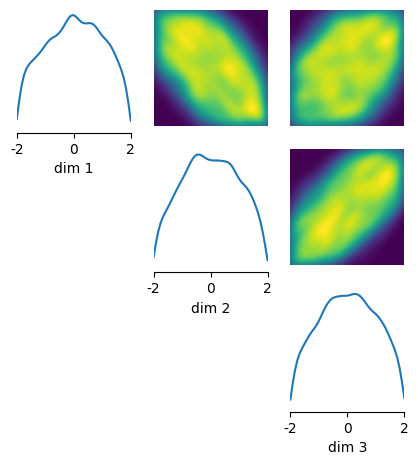

In [4]:
posterior_samples = posterior.sample((5000,))

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-2.0, 2.0]] * 3),
    offdiag=["kde"],
    diag=["kde"],
    figsize=(5, 5),
)

The 1D and 2D marginals of the posterior fill almost the entire parameter space! Also, the Pearson correlation coefficient matrix of the marginal shows rather weak interactions (low correlations):


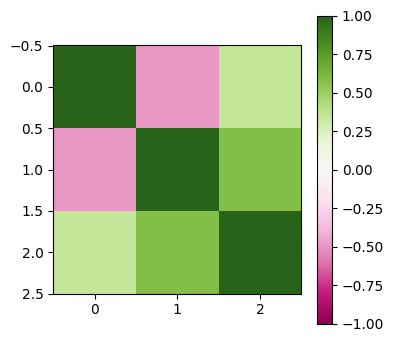

In [5]:
corr_matrix_marginal = np.corrcoef(posterior_samples.T)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap="PiYG")
_ = fig.colorbar(im)

It might be tempting to conclude that the experimental data barely constrains our parameters and that almost all parameter combinations can reproduce the experimental data. As we will show below, this is not the case.


Because our toy posterior has only three parameters, we can plot posterior samples in a 3D plot:


In [6]:
rc("animation", html="html5")

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))


def init():
    (line,) = ax.plot([], [], lw=2)
    line.set_data([], [])
    return (line,)


def animate(angle):
    num_samples_vis = 1000
    line = ax.scatter(
        posterior_samples[:num_samples_vis, 0],
        posterior_samples[:num_samples_vis, 1],
        posterior_samples[:num_samples_vis, 2],
        zdir="z",
        s=15,
        c="#2171b5",
        depthshade=False,
    )
    ax.view_init(20, angle)
    return (line,)


anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=range(0, 360, 5), interval=150, blit=True
)

plt.close()

In [7]:
HTML(anim.to_html5_video())

Clearly, the range of admissible parameters is constrained to a narrow region in parameter space, which had not been evident from the marginals.


If the posterior has more than three dimensions, inspecting all dimensions at once will not be possible anymore. One way to still reveal structures in high-dimensional posteriors is to inspect 2D-slices through the posterior. In `sbi`, this can be done with the `conditional_pairplot()` function, which computes the conditional distributions within the posterior. We can slice (i.e. condition) the posterior at any location, given by the `condition`. In the plot below, for all upper diagonal plots, we keep all but two parameters constant at values sampled from the posterior, and inspect what combinations of the remaining two parameters can reproduce experimental data. For the plots on the diagonal (the 1D conditionals), we keep all but one parameter constant.


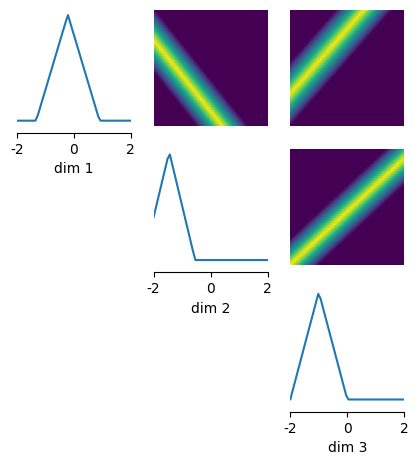

In [8]:
condition = posterior.sample((1,))

_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[-2.0, 2.0]] * 3),
    figsize=(5, 5),
)

This plot looks completely different from the marginals obtained with `pairplot()`. As it can be seen on the diagonal plots, if all parameters but one are kept constant, the remaining parameter has to be tuned to a narrow region in parameter space. In addition, the upper diagonal plots show strong correlations: deviations in one parameter can be compensated through changes in another parameter.


We can summarize these correlations in a conditional correlation matrix, which computes the Pearson correlation coefficient of each of these pairwise plots. This matrix (below) shows strong correlations between many parameters, which can be interpreted as potential compensation mechansims:


/opt/homebrew/Caskroom/miniforge/base/envs/sbi_env/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


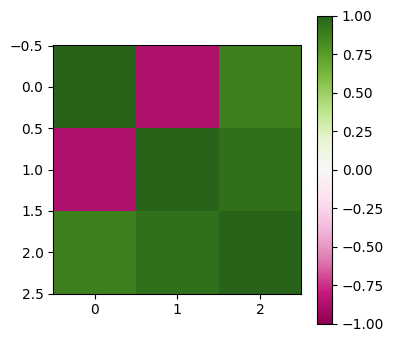

In [9]:
cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[-2.0, 2.0]] * 3),
)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap="PiYG")
_ = fig.colorbar(im)

So far, we have investigated the conditional distribution only at a specific `condition` sampled from the posterior. In many applications, it makes sense to repeat the above analyses with a different `condition` (another sample from the posterior), which can be interpreted as slicing the posterior at a different location. Note that `conditional_corrcoeff()` can directly compute the matrix for several `conditions` and then outputs the average over them. This can be done by passing a batch of $N$ conditions as the `condition` argument.


## Sampling conditional distributions

So far, we have demonstrated how one can plot 2D conditional distributions with `conditional_pairplot()` and how one can compute the pairwise conditional correlation coefficient with `conditional_corrcoeff()`. In some cases, it can be useful to keep a subset of parameters fixed and to vary **more than two** parameters. This can be done by sampling the conditonal posterior $p(\theta_i | \theta_{j \neq i}, x_o)$. As of `sbi` `v0.18.0`, this functionality requires using the [sampler interface](https://sbi-dev.github.io/sbi/tutorial/11_sampler_interface/). In this tutorial, we demonstrate this functionality on a linear gaussian simulator with four parameters. We would like to fix the forth parameter to $\theta_4=0.2$ and sample the first three parameters given that value, i.e. we want to sample $p(\theta_1, \theta_2, \theta_3 | \theta_4 = 0.2, x_o)$. For an application in neuroscience, see [Deistler, Gonçalves, Macke, 2021](https://www.biorxiv.org/content/10.1101/2021.07.30.454484v4.abstract).


In this tutorial, we will use SNPE, but the same also works for SNLE and SNRE. First, we define the prior and the simulator and train the deep neural density estimator:


In [10]:
import torch

from sbi.inference import (
    SNPE,
    MCMCPosterior,
    posterior_estimator_based_potential,
    prepare_for_sbi,
    simulate_for_sbi,
)
from sbi.utils import BoxUniform

num_dim = 4
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))


def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1


simulator, prior = prepare_for_sbi(linear_gaussian, prior)

inference = SNPE()
theta, x = simulate_for_sbi(simulator, prior, 1000)
posterior_estimator = inference.append_simulations(theta, x).train()

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 118 epochs.

Next, we follow the sampler interface and create a potential_function. The observation in this example is `x_o=[1, 1, 1, 1]`.


In [11]:
x_o=torch.ones(4)

potential_fn, theta_transform = posterior_estimator_based_potential(
    posterior_estimator, prior=prior, x_o=x_o
)

Now we want to build the conditional potential (please read throught the [sampler interface tutorial](https://sbi-dev.github.io/sbi/tutorial/11_sampler_interface/) for an explanation of potential functions). For this, we have to pass a `condition`. In our case, we want to condition the forth parameter on $\theta_4=0.2$. Regardless of how many parameters one wants to condition on, in `sbi`, one has to pass a `condition` value for all parameters. The first three values will simply be ignored. We can tell the algorithm which parameters should be kept fixed and which ones should be sampled with the argument `dims_to_sample`.


In [12]:
conditioned_potential_fn, restricted_tf, restricted_prior = conditional_potential(
    potential_fn=potential_fn,
    theta_transform=theta_transform,
    prior=prior,
    condition=torch.as_tensor(
        [0.0, 0.0, 0.0, 0.2]
    ),  # the first three values are arbitrary and are ignored internally
    dims_to_sample=[0, 1, 2],
)

Finally, we have to build a sampler for the `conditioned_potential_fn`. E.g., we can sample the conditional posterior with MCMC:


In [13]:
mcmc_posterior = MCMCPosterior(
    potential_fn=conditioned_potential_fn,
    theta_transform=restricted_tf,
    proposal=restricted_prior,
    method="slice_np_vectorized",
    num_chains=20,
).set_default_x(x_o)
cond_samples = mcmc_posterior.sample((100,))

Running vectorized MCMC with 20 chains:   0%|          | 0/3000 [00:00<?, ?it/s]

The resulting samples are 3-dimensional, corresponding to $[\theta_1, \theta_2, \theta_3]$, sampled from $p(\theta_1, \theta_2, \theta_3 | \theta_4=0.2, x_o)$.


In [14]:
print(cond_samples.shape)

torch.Size([100, 3])


We can also plot them with `pairplot`:


(<Figure size 800x800 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>]], dtype=object))

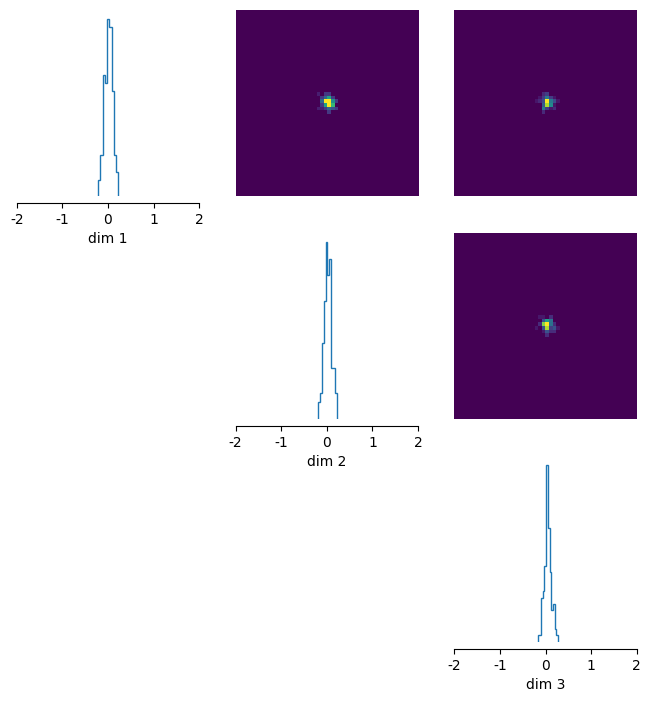

In [15]:
pairplot(cond_samples, limits=[[-2, 2], [-2, 2], [-2, 2], [-2, 2]], figsize=(8, 8),
         hist_diag=dict(bins="auto"))